# Import library
Import the relevant python library

In [ ]:
import pandas as pd
import geopandas as gpd
from model.model import ProOE
from importlib.machinery import SourceFileLoader

# Hyperparameters

Setting the hyperparameters.

``Note:`` We set `num_realizations = 3`, which helps to get testing results quickly, but it may not generate the best results.

In [2]:
class Args:
    pass
args = Args()
args.Flows_suffix = ''     
args.flow_threshold = 0  # Threshold to filter out the flows

# Column names in the respective files
args.unitid_name = 'LocationID'  # Column name for unit id in spatialunit.geojson
args.Oid_name = 'O_id'  # Column name for origin id in flow.csv
args.Did_name = 'D_id'  # Column name for destination id in flow.csv
args.flow_name = 'flow'  # Column name for flow in flow.csv
args.distance_name = 'distance'  # Column name for distance in distance.csv

# Model fitting parameters
args.max_iter = 200  # Maximum number of iterations to fit the model
args.min_iter = 50  # Minimum number of iterations to fit the model
args.num_realizations = 3  # Number of realizations to run

args.spatial_continuity_method = 'Adj' # The method for spatial continuity constrains, including geographic adjacency(Adj) and spatial clusting(HDBSCAN)
args.alpha = 2  # Parameter for spatial continuity guidance

args.seed = 0  # Random seed to use
args.verbose = False  # Display detailed information during runtime

# Main Process Flow

1. `Data Reading`:       Read the raw data (spatial units 'Vs', Trip table 'Es', and distance table 'Ds' between spatial units)
2. `Data Processing`:       Data cleaning and filtering (filter the spatial units with interactions and retain the corresponding data of the distance table)
3. `Model Iteration`:       Run the ProOE model
4. `Result Saving`:       Save the results in the './data/output/{dataset}/' folder
5. `Visualization`:       Draw the processing results of each dataset (spatial fuzzy communities division results, Trip Volume Matrix, Confidence Index, Certainty Index) 

In [3]:
def run_prooe(dataset, K):
    args.dataset = dataset  # Dataset name
    args.K = K   # Number of communities
    
    print(f'Running ProOE for dataset: {dataset} with K={K}')
    
    print('Reading raw data...')
    Vs = gpd.read_file(f'./data/input/{args.dataset}/SpatialUnit.geojson', dtype={args.unitid_name: str})
    Vs[args.unitid_name] = Vs[args.unitid_name].astype(str)
    Es = pd.read_csv(f'./data/input/{args.dataset}/Flows' + args.Flows_suffix + '.csv', dtype={args.Oid_name: str, args.Did_name: str, args.flow_name: float})
    Ds = pd.read_csv(f'./data/input/{args.dataset}/Distances.csv', dtype={args.Oid_name: str, args.Did_name: str , args.distance_name: float})
    
    print('Data preprocessing...')
    utils = SourceFileLoader('utils', './model/utils.py').load_module()
    Es_p, Distances_p, Adj_p, Vs_p, Vs_coord_p = utils.pre_data(Vs, Es, Ds, args) 

    print('Running ProOE...')
    ProOE_model = ProOE(Es_p, Distances_p, Adj_p, Vs_p, Vs_coord_p, args.K, max_iter=args.max_iter, spatial_continuity_method = args.spatial_continuity_method, alpha = args.alpha, min_iter= args.min_iter, num_realizations=args.num_realizations, seed=args.seed, verbose=args.verbose)
    
    print('Saving results...')
    ProOE_model.save_result(Vs, args.unitid_name,f'./data/output/{args.dataset}/', args.Flows_suffix+'_'+str(args.K))

    print('Plotting results...')
    visual_utils = SourceFileLoader('visual_utils', './visual_utils.py').load_module()
    visual_utils.plot_all(args.dataset, '', args.K)

# Simulated dataset - spatial heterogeneity
For dataset heterogeneity, we established 4 communities and three levels of intensity (heterogeneity), namely high (10,000), medium (1,000), and low (1,000), to verify the effectiveness of the method in this study for spatial heterogeneity. The community intensity from the first community in the upper left to the fourth community in the lower right was medium, low, medium, and high, respectively. 
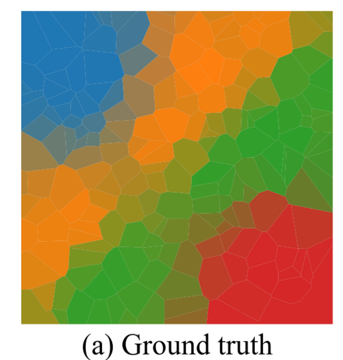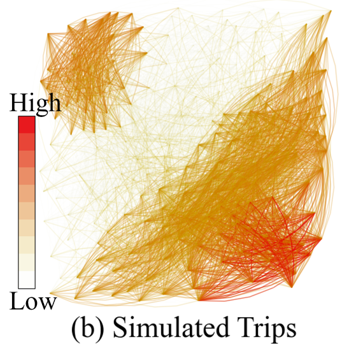

Running ProOE for dataset: heterogeneity with K=4
Reading raw data...
Data preprocessing...
Running ProOE...
Selected distribution: lognormal (R² = 0.9903)
    Realization1/3 iter:51/200, loglikelihood:92136407.778, time: 1.47s The optimal Loglikelihood value of the 1 fitting is: 92152669.2815882, which is the current Optimal Log_Likelihood value
    Realization2/3 iter:51/200, loglikelihood:91252878.867, time: 1.41s  
    Realization3/3 iter:59/200, loglikelihood:92109970.912, time: 1.66s  
Saving results...
Plotting results...


Processing rows: 100%|██████████| 195/195 [00:00<00:00, 21665.94it/s]
./visual_utils.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


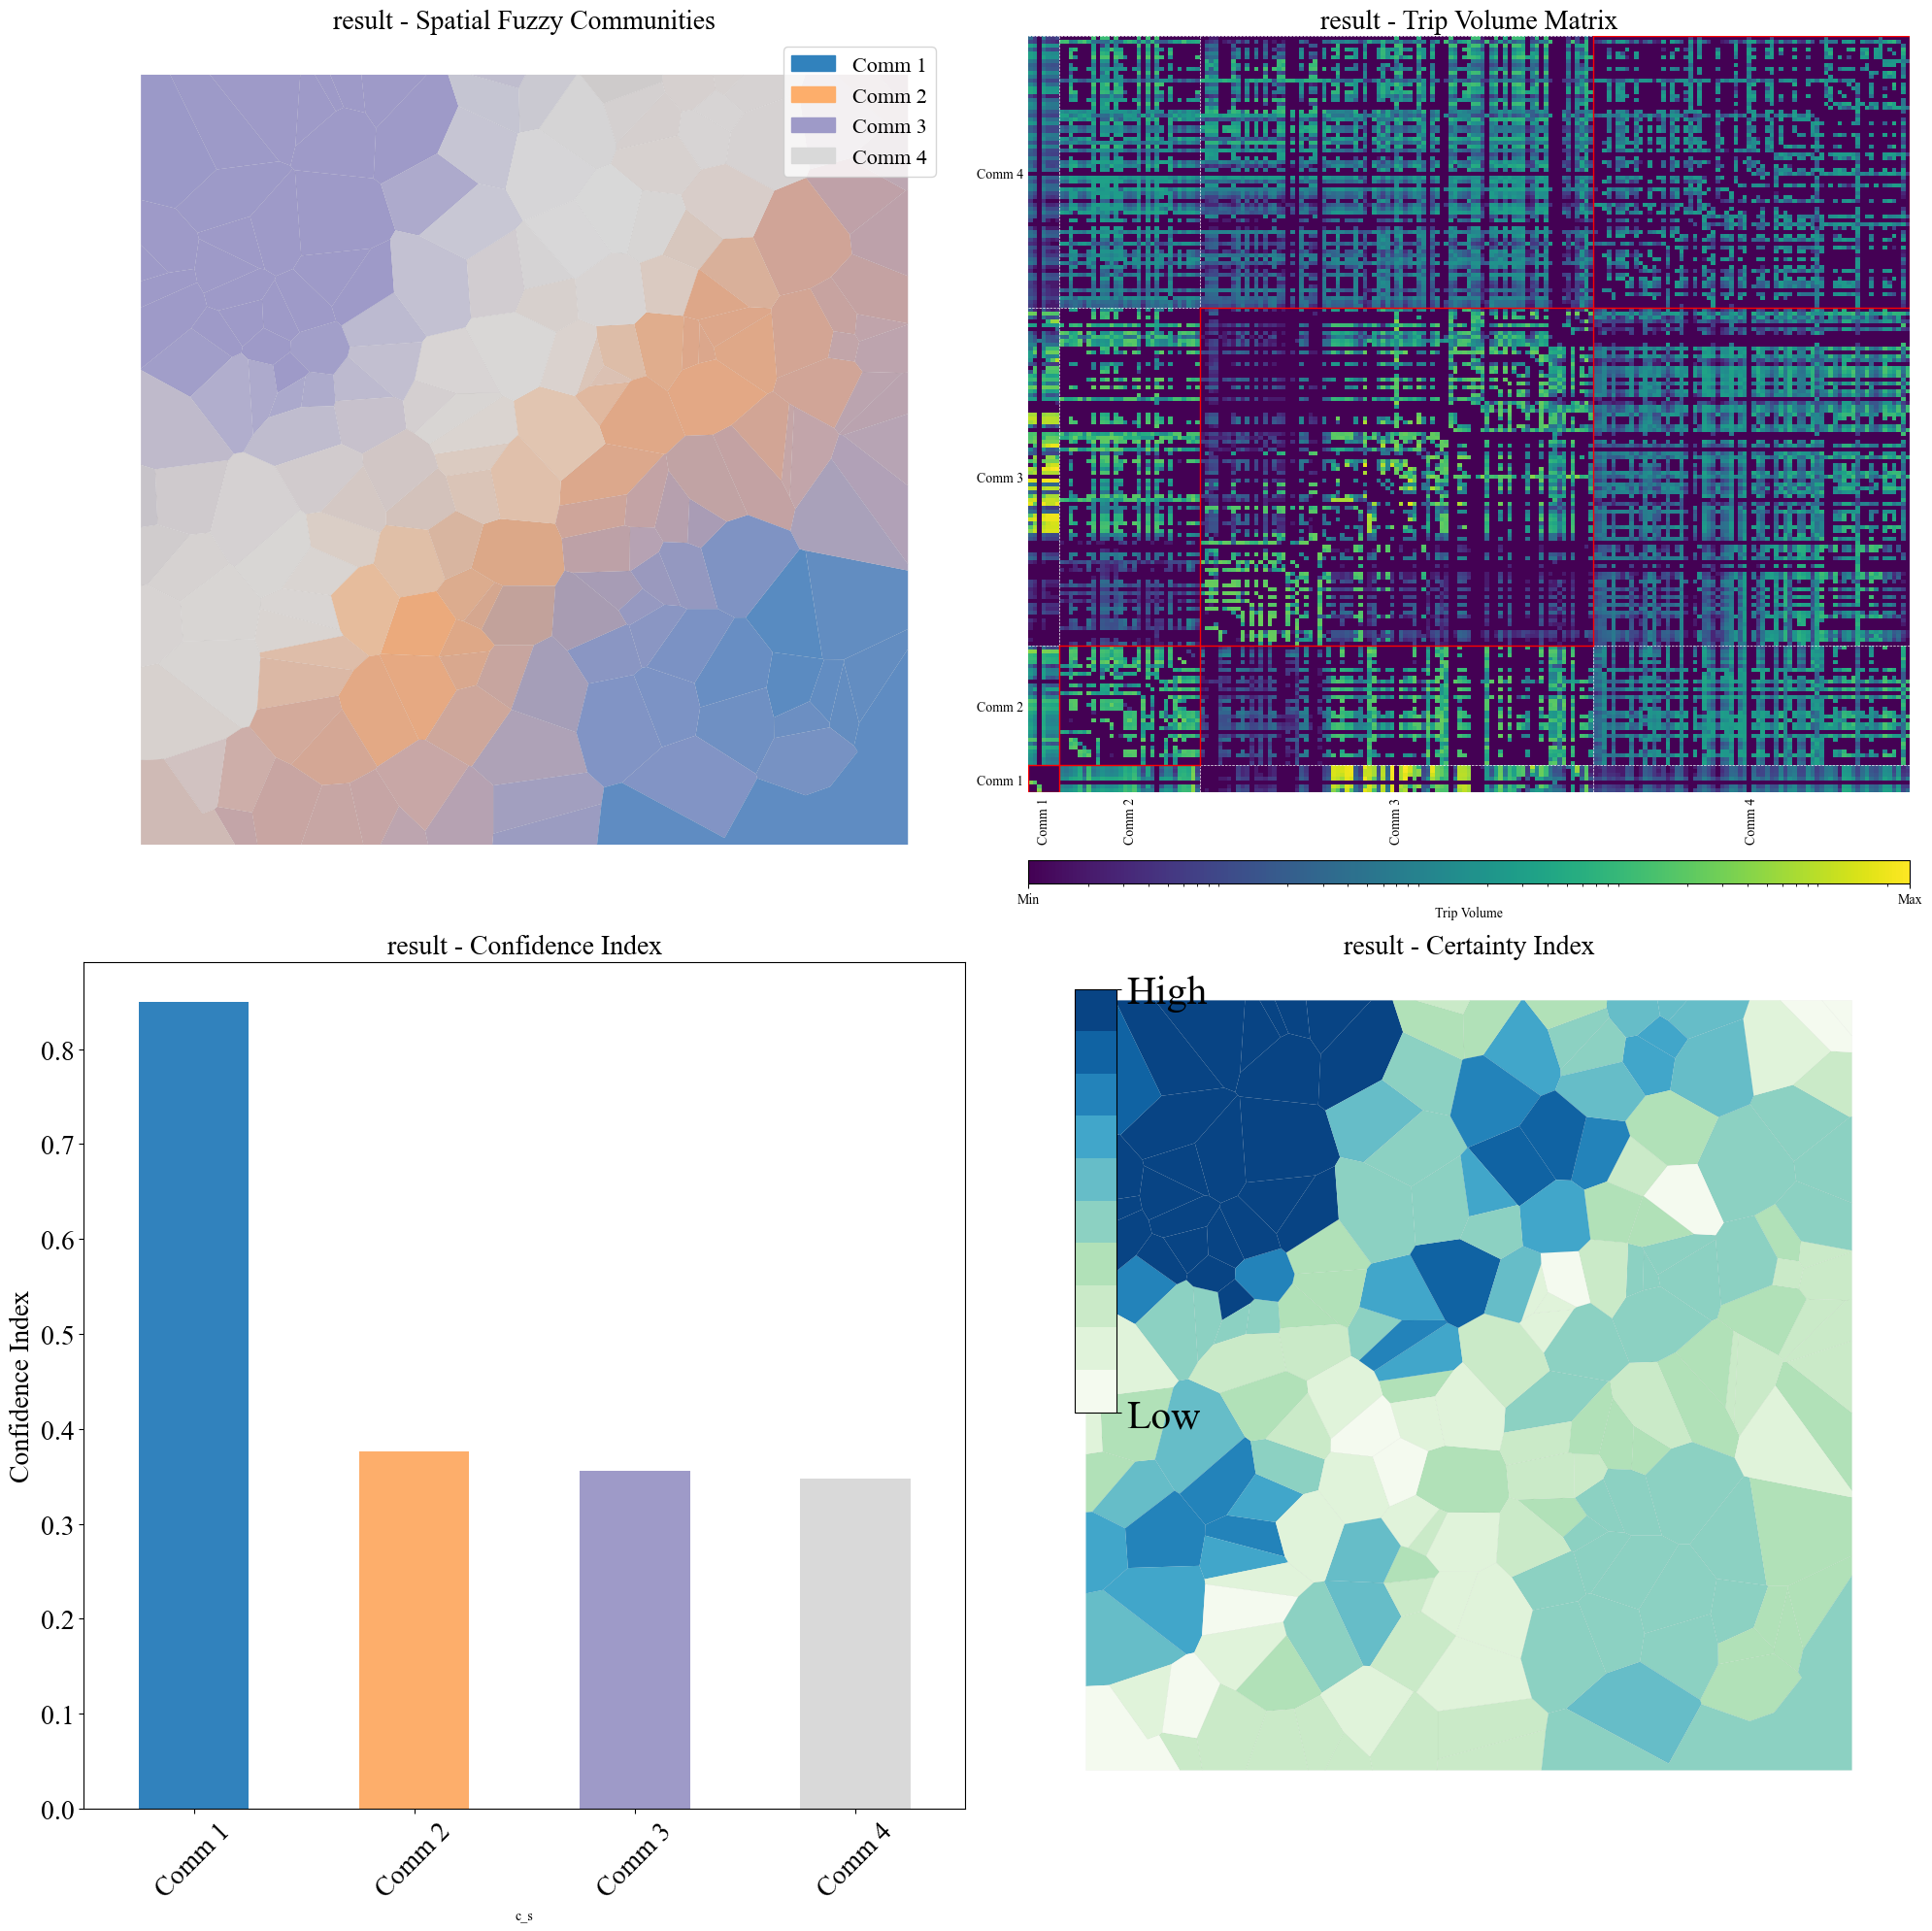

In [4]:
dataset, K = ('heterogeneity', 4)
run_prooe(dataset, K)

# Simulated dataset - spatial fuzziness
In dataset fuzziness, we established 4 communities; the distance weights were significantly more important than those in the other two datasets, which can better highlight the ambiguity of the community boundaries.

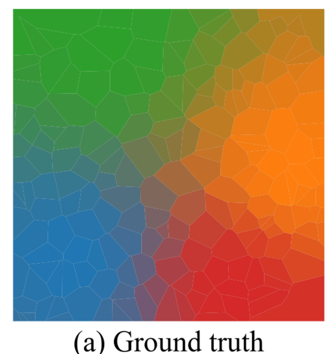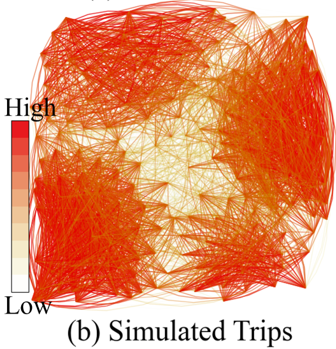

Running ProOE for dataset: fuzziness with K=4
Reading raw data...
Data preprocessing...
Running ProOE...
Selected distribution: lognormal (R² = 0.9946)
    Realization1/3 iter:87/200, loglikelihood:79076970.575, time: 2.86s The optimal Loglikelihood value of the 1 fitting is: 79081654.23269981, which is the current Optimal Log_Likelihood value
    Realization2/3 iter:51/200, loglikelihood:78921530.633, time: 1.76s  
    Realization3/3 iter:63/200, loglikelihood:78954699.463, time: 2.07s  
Saving results...
Plotting results...


Processing rows: 100%|██████████| 192/192 [00:00<00:00, 47972.02it/s]
./visual_utils.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


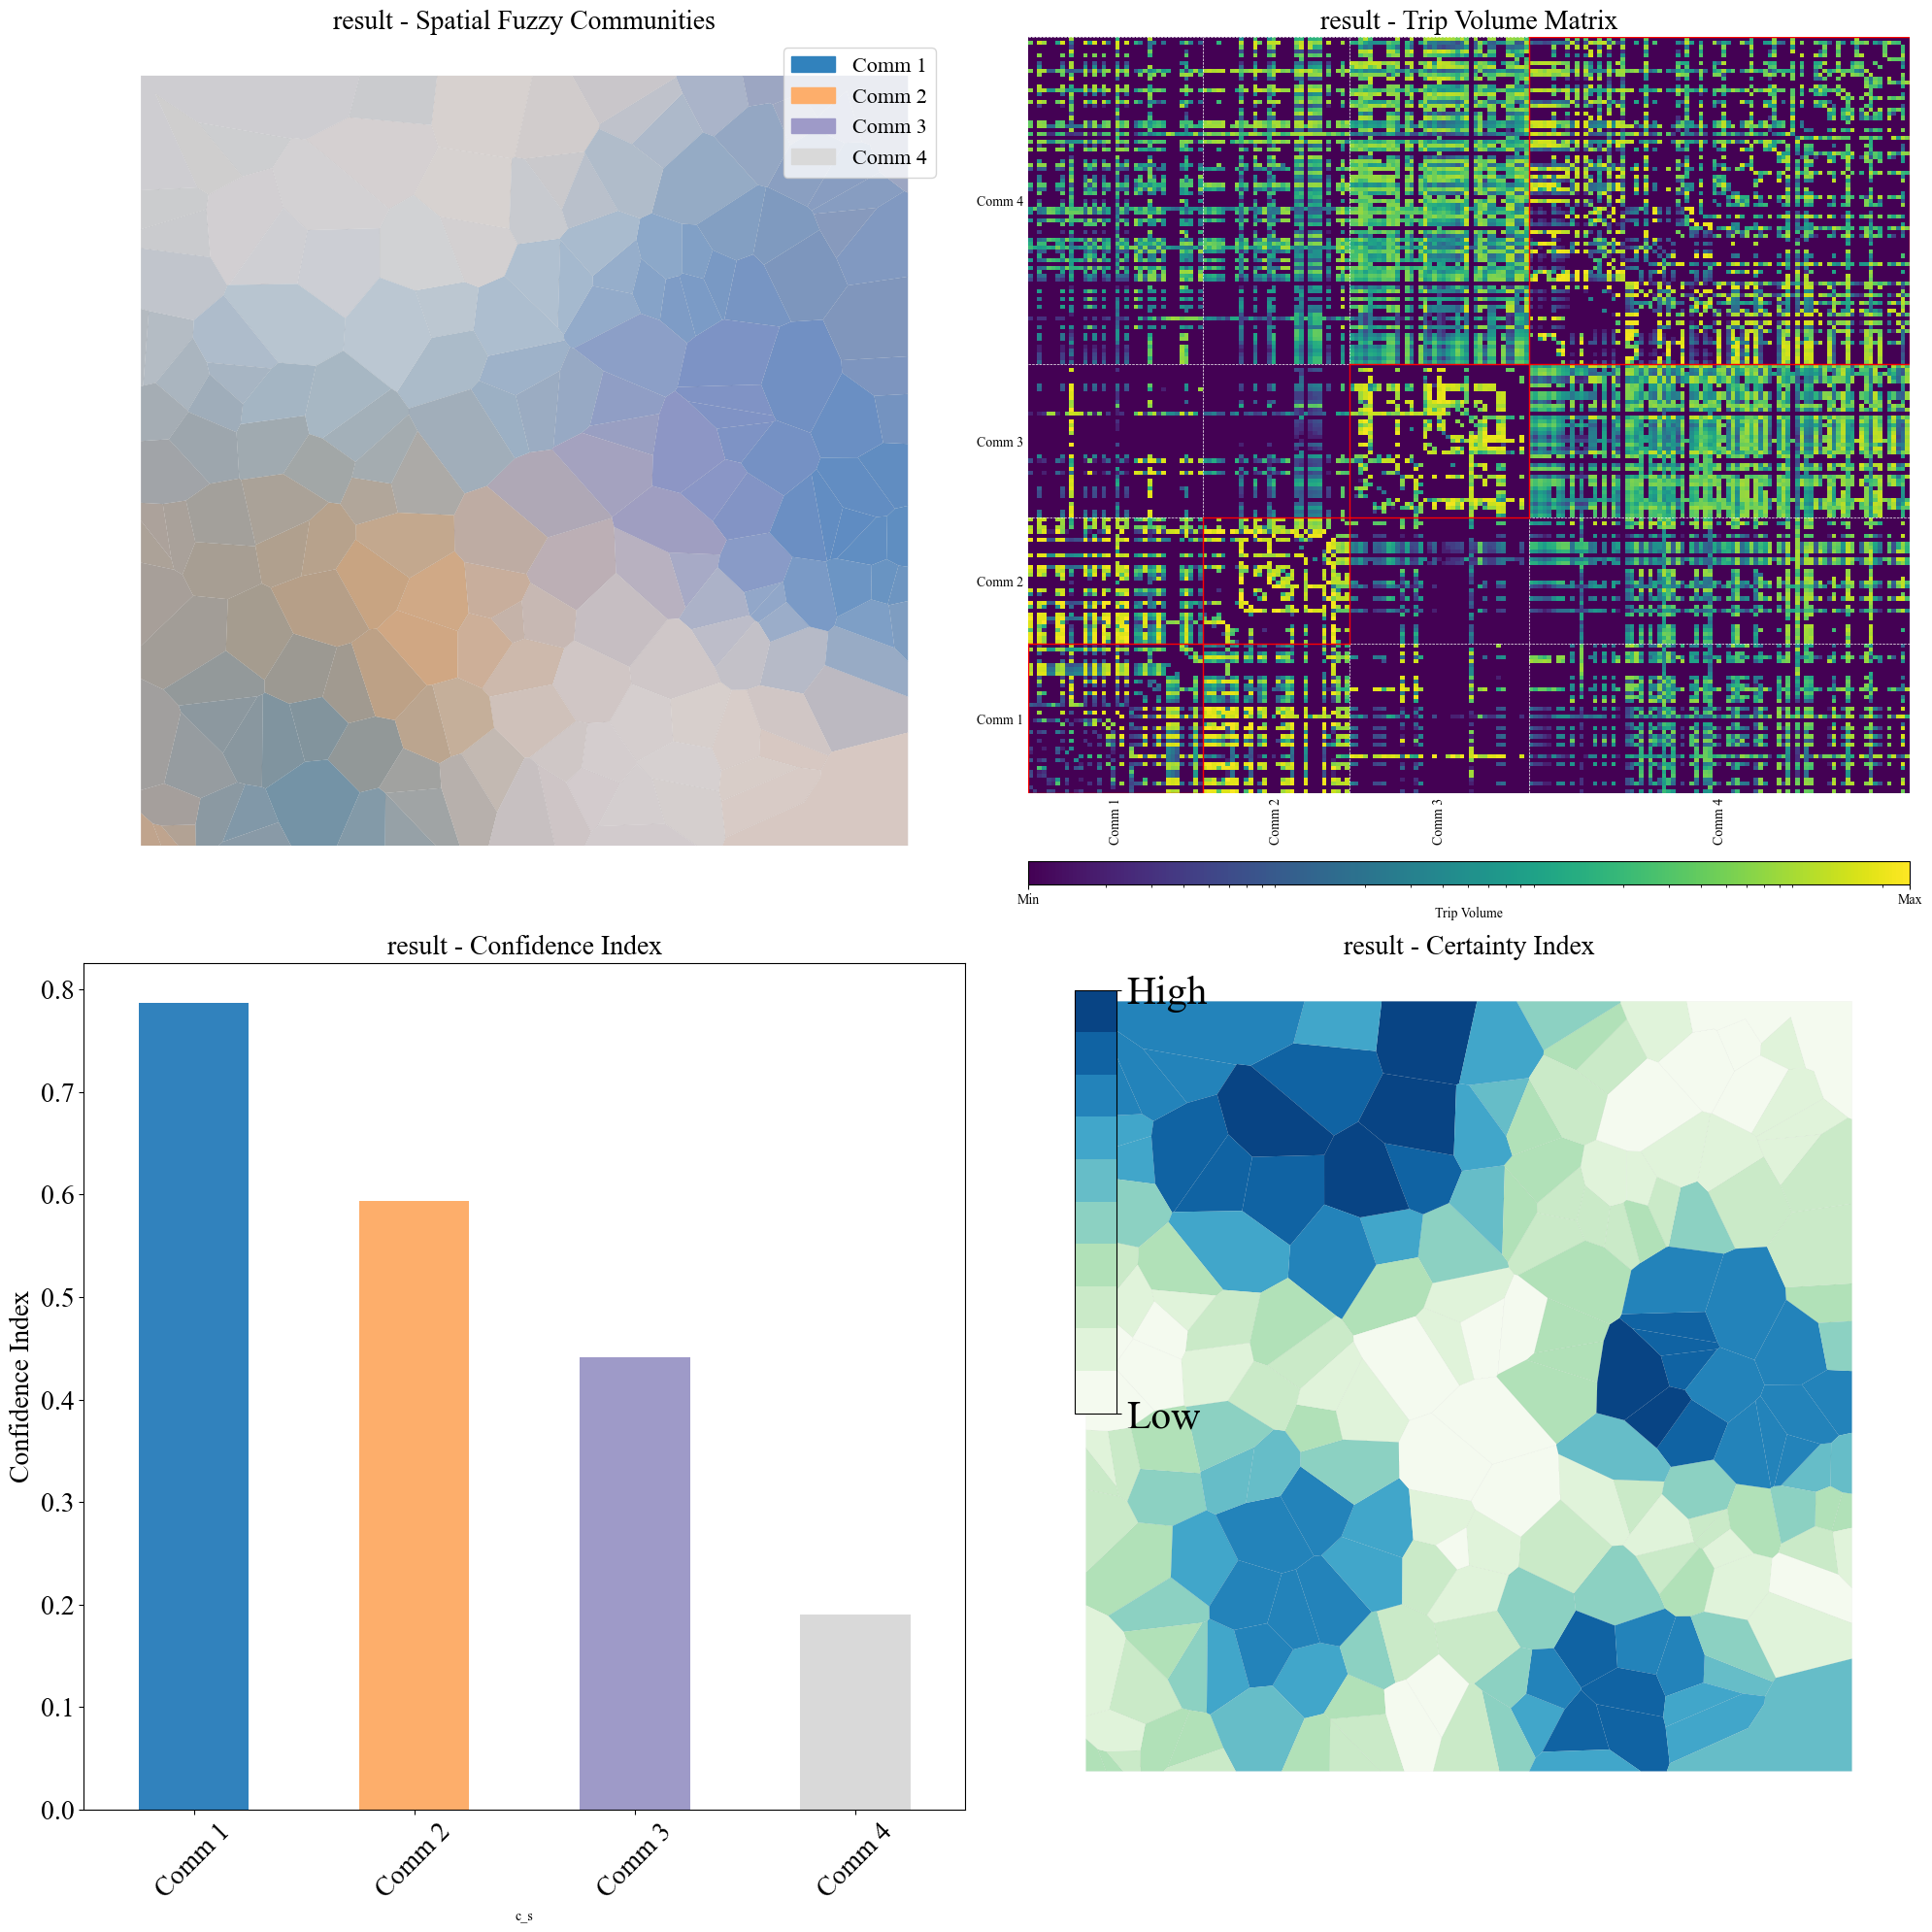

In [5]:
dataset, K = ('fuzziness', 4)
run_prooe(dataset, K)

# Simulated dataset - spatial continuous
In the continuous dataset, we established 3 communities, then randomly selected 10 spatial units from each of the 2 communities as abnormal areas, and randomly generated a large number of trips between these abnormal areas.

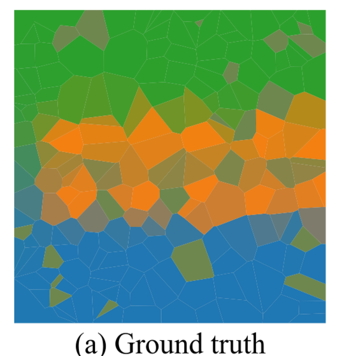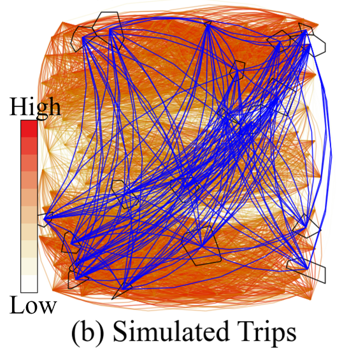

Running ProOE for dataset: continuous with K=3
Reading raw data...
Data preprocessing...
Running ProOE...
Selected distribution: lognormal (R² = 0.9690)
    Realization1/3 iter:82/200, loglikelihood:117302523.552, time: 1.84s The optimal Loglikelihood value of the 1 fitting is: 117339754.47380936, which is the current Optimal Log_Likelihood value
    Realization2/3 iter:51/200, loglikelihood:117270935.971, time: 1.33s  
    Realization3/3 iter:51/200, loglikelihood:117187043.443, time: 1.27s  
Saving results...
Plotting results...


Processing rows: 100%|██████████| 196/196 [00:00<00:00, 49029.86it/s]
./visual_utils.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


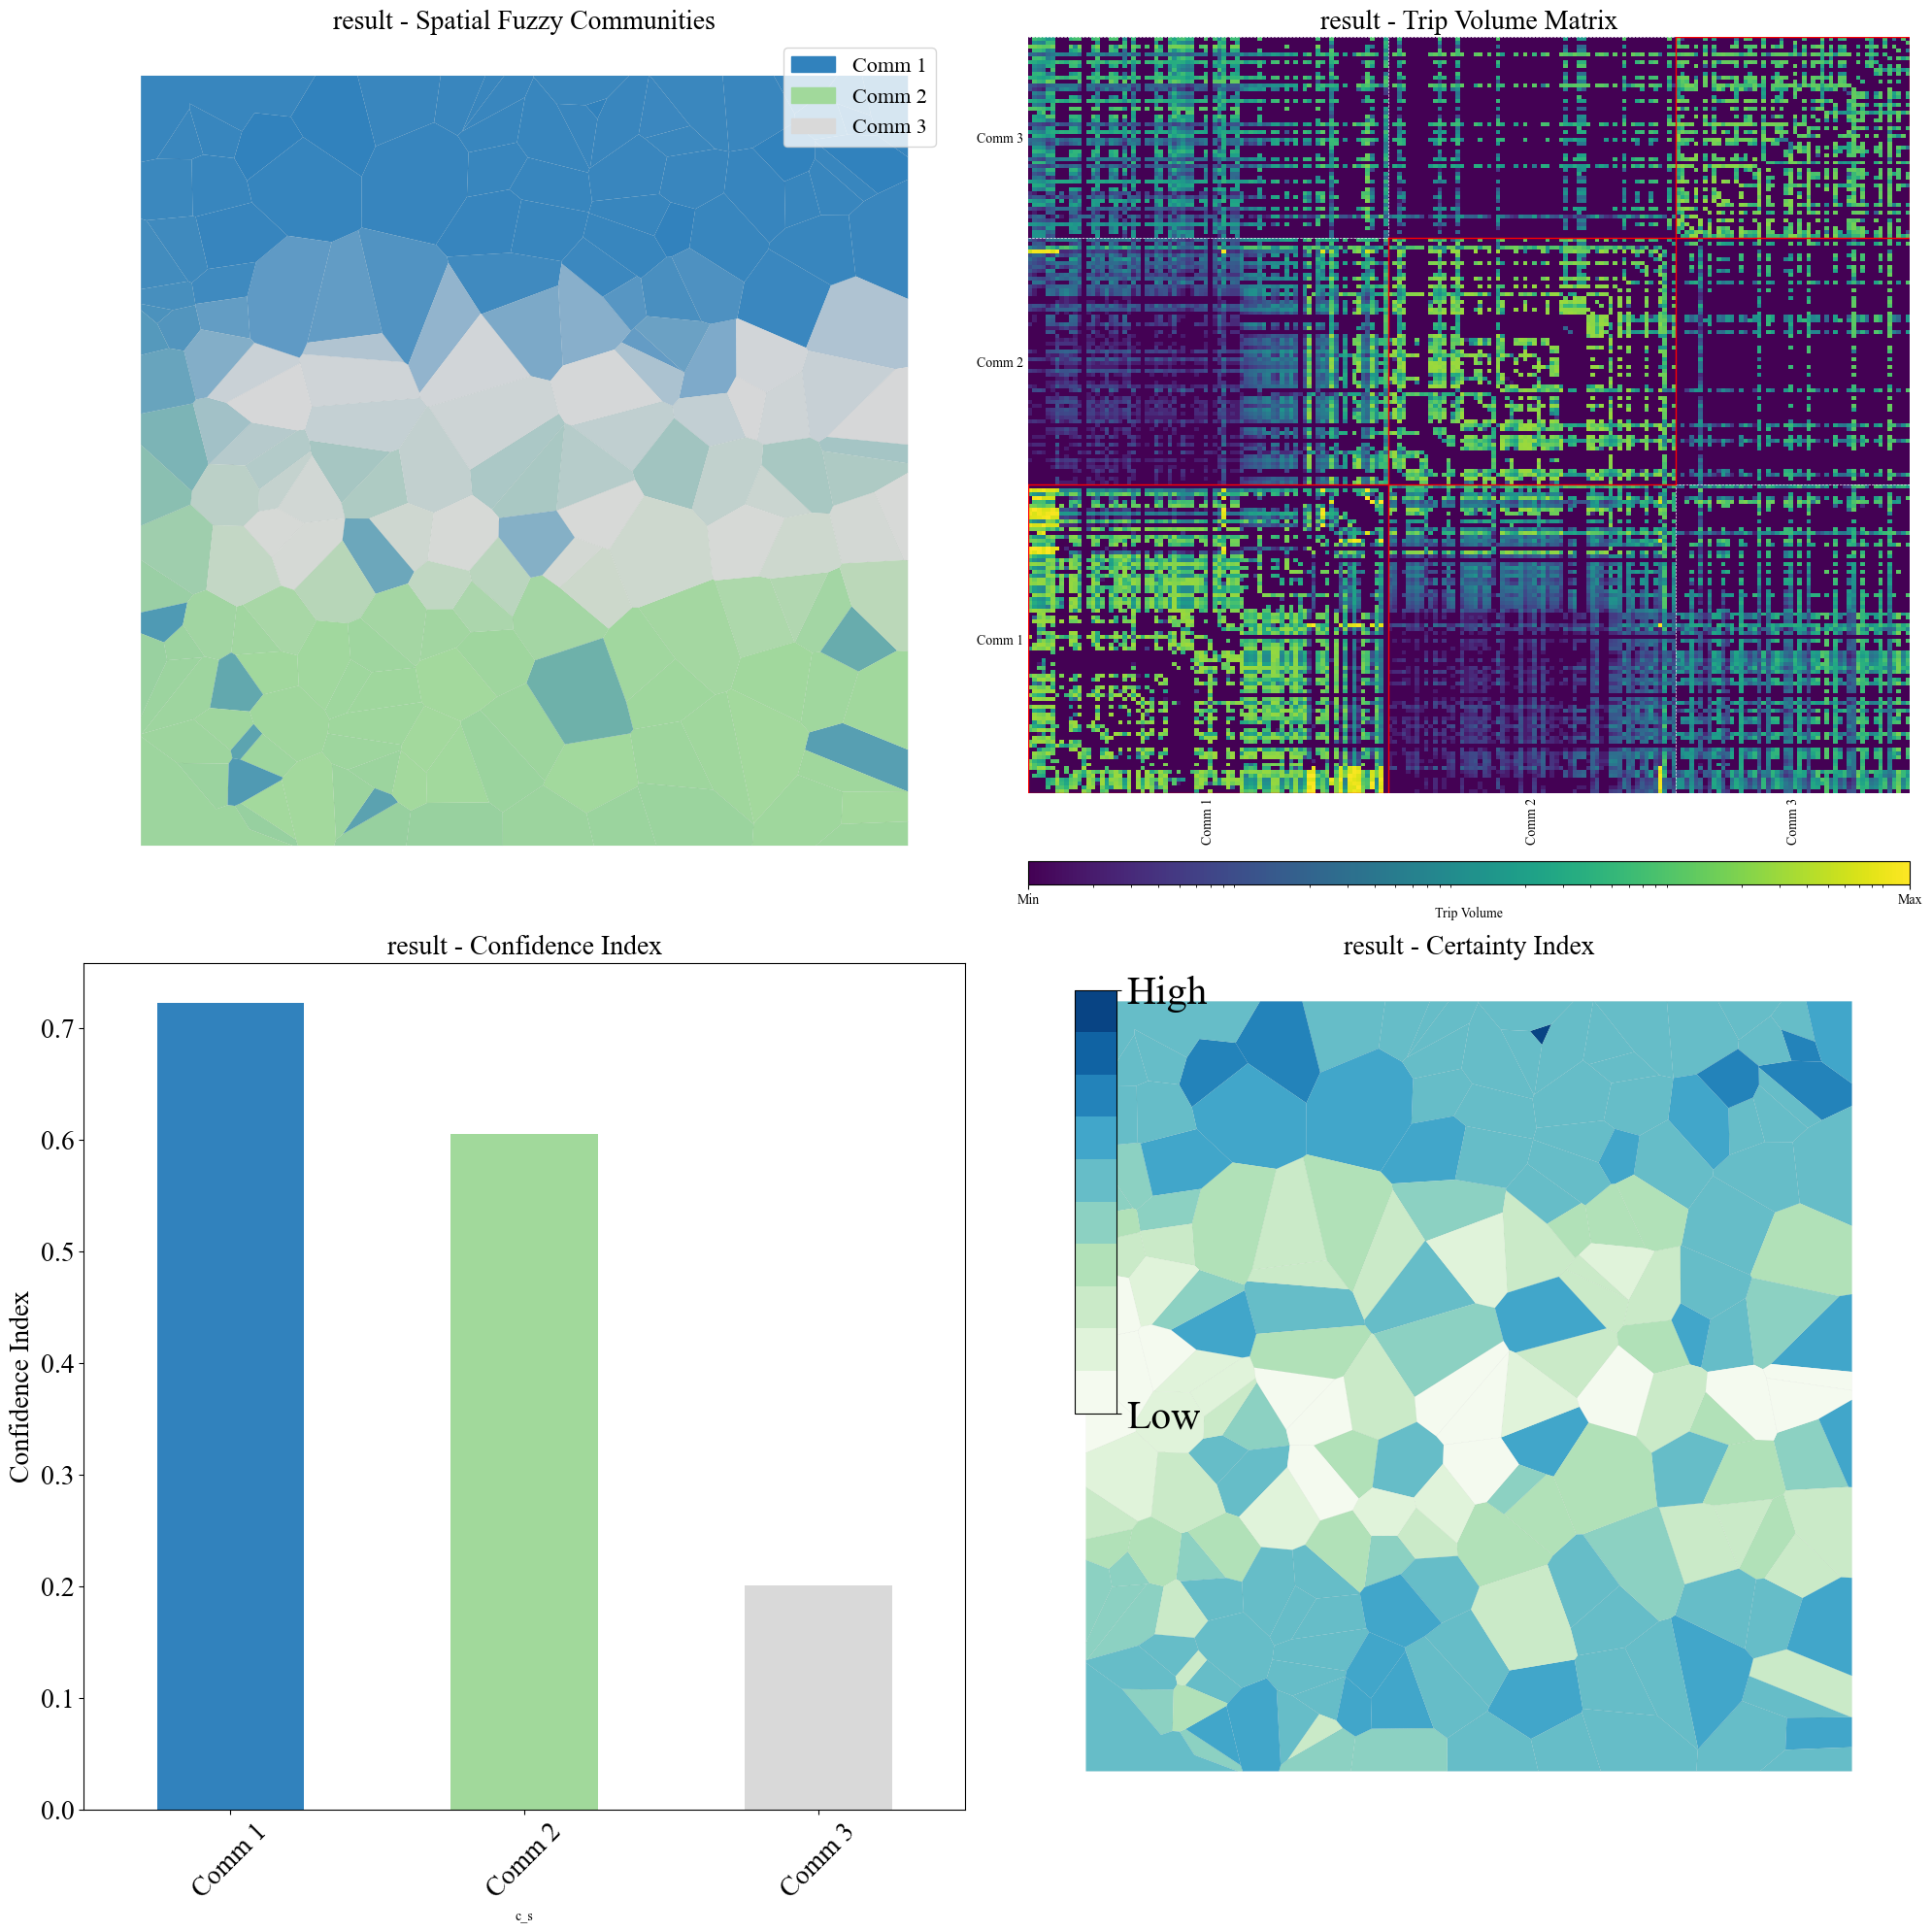

In [6]:
dataset, K = ('continuous', 3)
run_prooe(dataset, K)

# Real-world dataset - New York Taxi
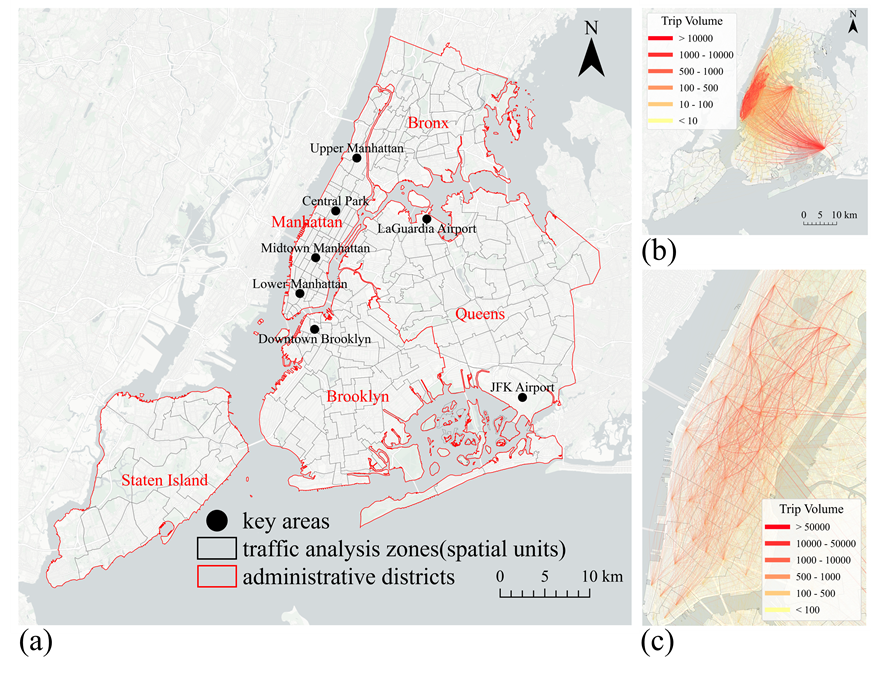

Running ProOE for dataset: NYC_taxi with K=10
Reading raw data...
Data preprocessing...
Running ProOE...
Selected distribution: lognormal (R² = 0.9148)
    Realization1/3 iter:52/200, loglikelihood:77969792.983, time: 2.35s The optimal Loglikelihood value of the 1 fitting is: 78429503.72478662, which is the current Optimal Log_Likelihood value
    Realization2/3 iter:56/200, loglikelihood:77983550.444, time: 2.59s  
    Realization3/3 iter:52/200, loglikelihood:77652638.567, time: 2.46s  
Saving results...
Plotting results...


Processing rows: 100%|██████████| 258/258 [00:00<00:00, 42997.99it/s]
./visual_utils.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


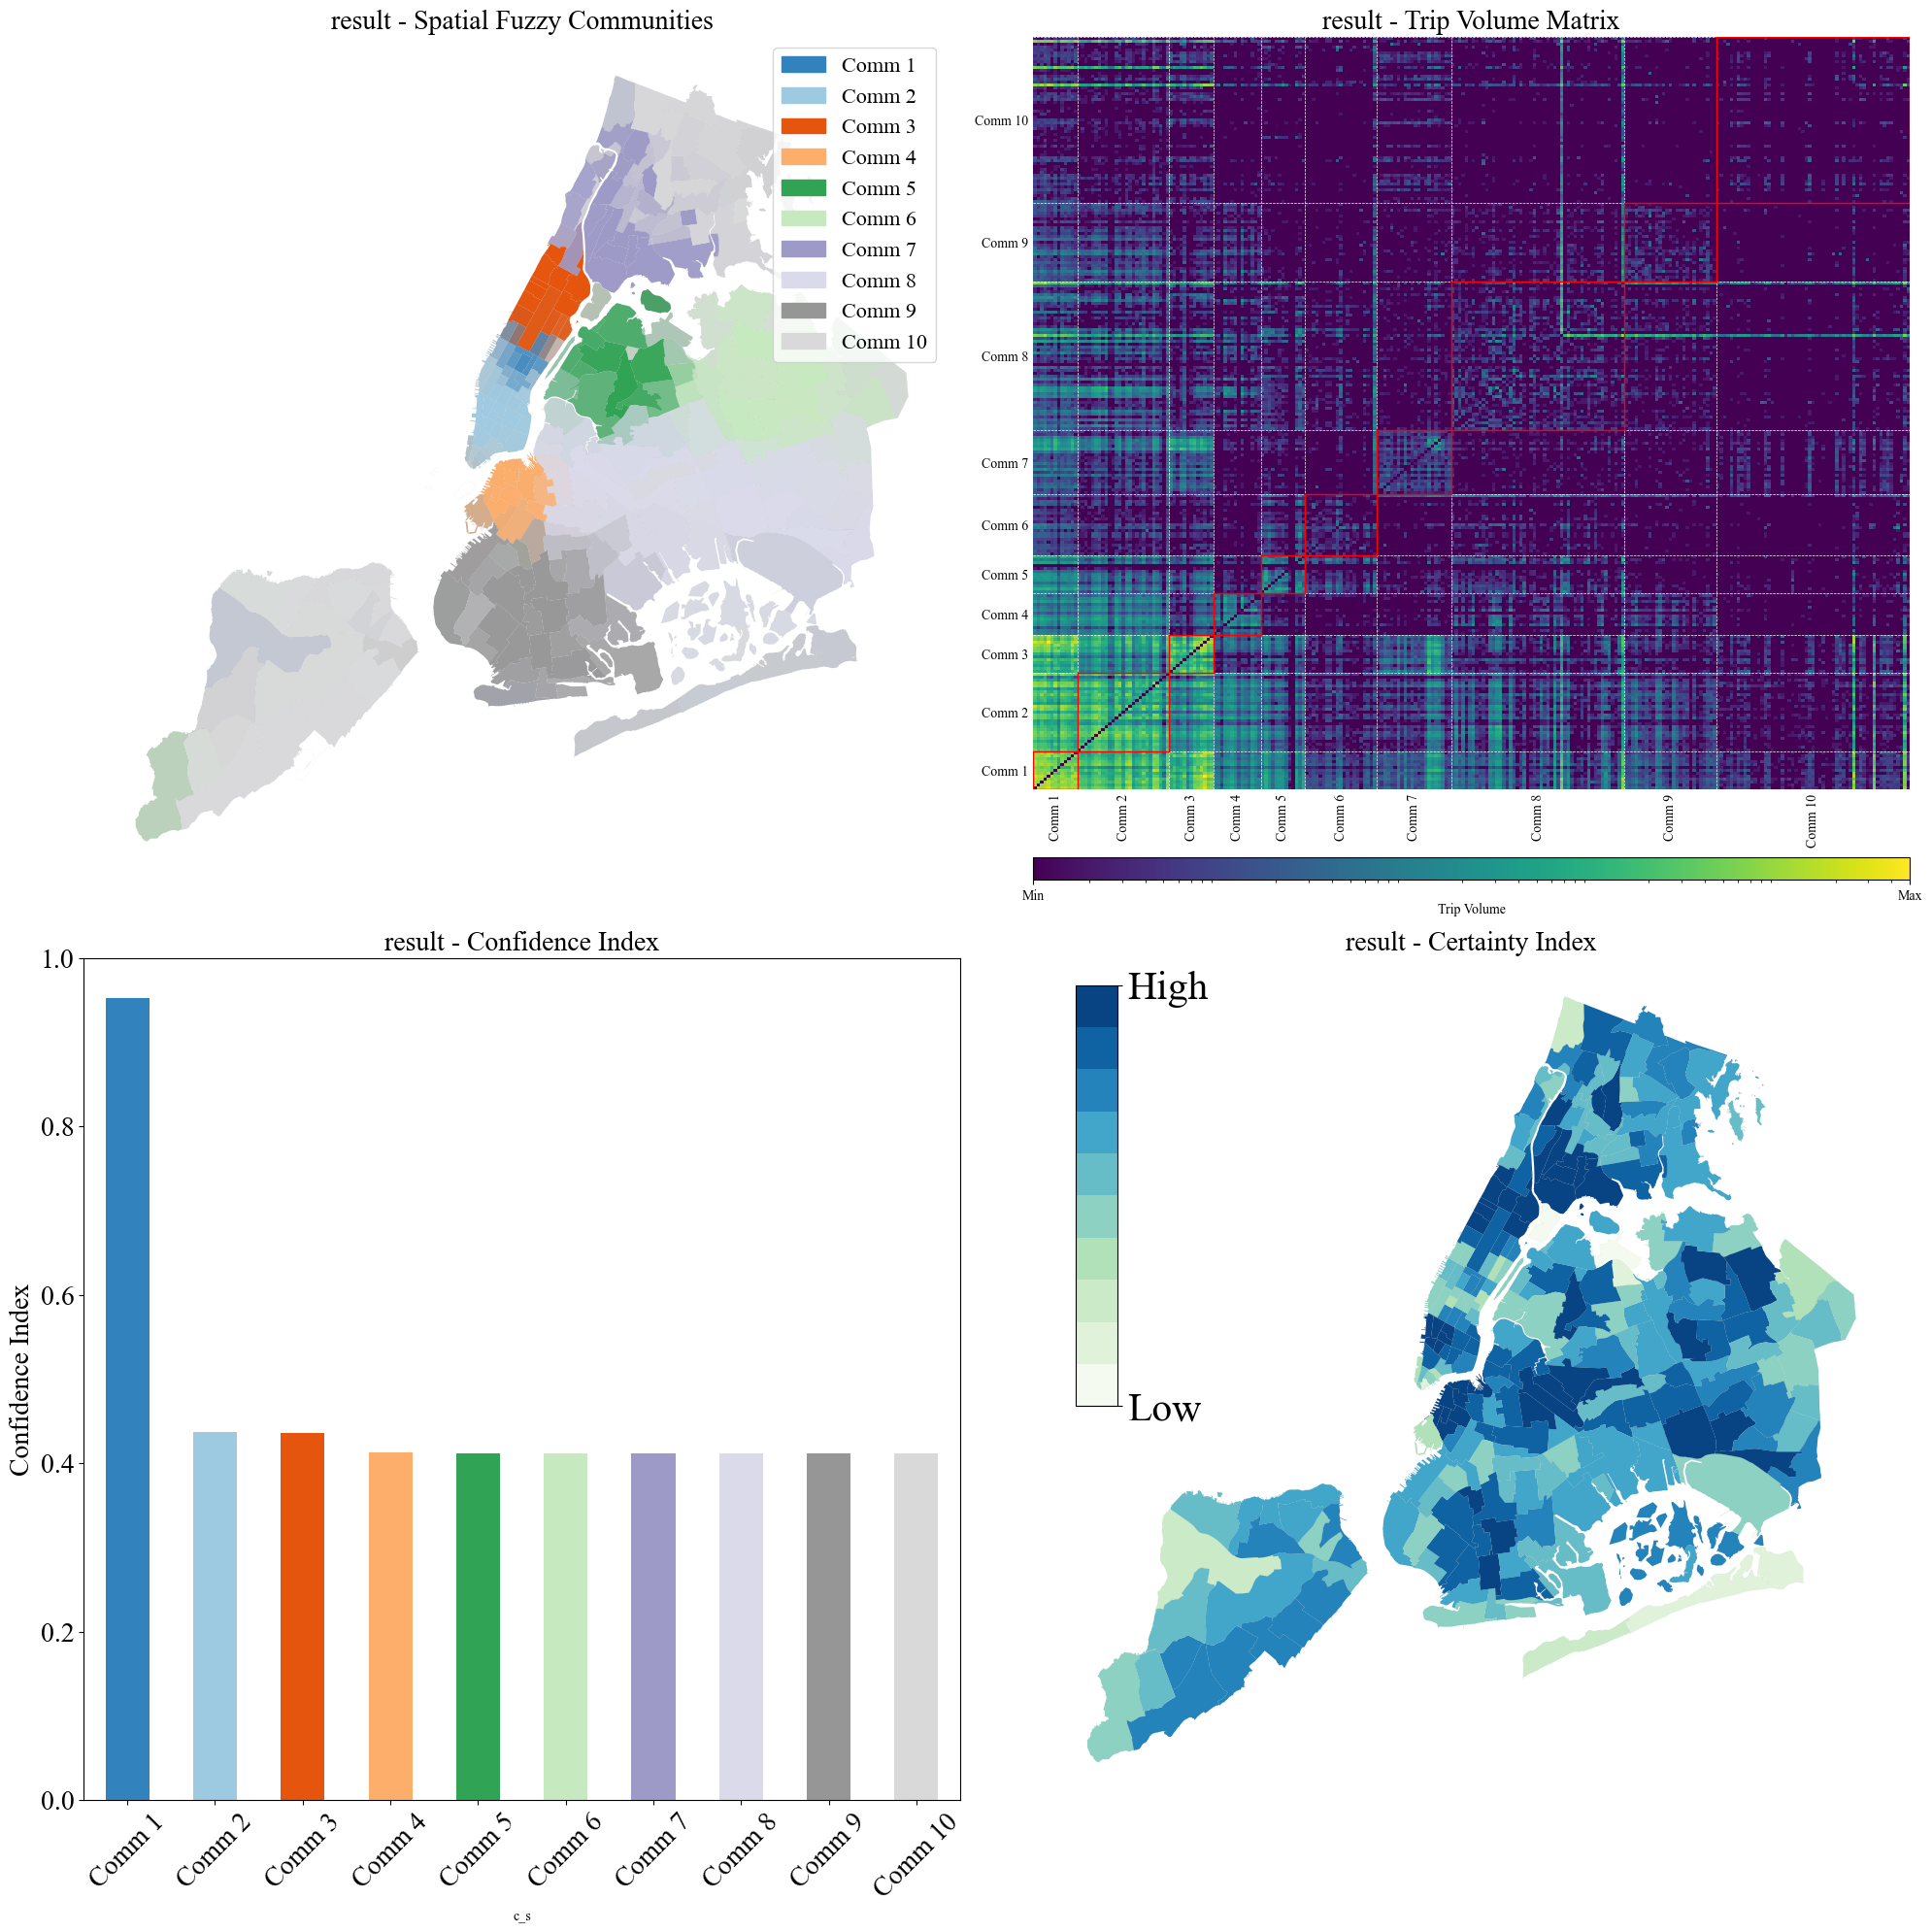

In [7]:
dataset, K = ('NYC_taxi', 10)
run_prooe(dataset, K)